## Fitbit Timeseries Project
#### Corey Solitaire   
`11-03-2020`

<div class="alert alert-block alert-info"><b></b></div>

## Executive Summary: 

*****

**Project Summary:**   
The purpose to this project was to clean and explore an unlabled fitness tracker dataset, to provide evidence to support characterization of individual and use time series analysis to predict two missing weeks of tracker data.  

**Background:**   
Here at Big Research Co.®, we love data so much - everyone wears Fitbits, even our employees! We believe these watches are the next step in the Big Data Industry and help enhance our current research. Our research spans from fitness equiptment and drug trials to very ethical human experimentation.
However, someone in a research and develoment mixed up the labels for our Fitbit data sets and one was left out.

**Process:**   
Data set was combined from 8 csv files in Excel.  97% of food log data missing, so values were dropped.  This resulted in a data frame what was 10 columns by 225 rows, with each row representing a specific day. Data was explored and weekly trends were obsereved.  Data was applied to several time series models, with a 7-day moving average providing the lowest RMSE.  When model was applied to test it resulted in a 29% improvement over baseline (last observed value)  

**Results and Conclusions:**   
General trends in the data demonstrate a slight upward trend in calories and activity over time, with the majority of higher activity levels occuring on the weekend.  The lack of regular exercise, the lenght of time sedintary, and the the missing food data suggest this fitness tracker belongs to an employee. While the model was able to improve on baseline observations I was not able to match a model to weekly seasdonality.  There exists the possibility that alternate modeling techiniques (TSA with Prophet) would return better results however that modeling technique was not included in this study.  

**Reccomendations:**   
- **Not Enough Data:** With only 7 months of data it was hard to pick up long term trends in seasonality.  More data would have yeilded better results.    
- **New Model:** Spending time refining previous-cycle model and exploring prophet would improve model forcasting.    
- **Cross Validation:** This model may work better on other CA counties, further investigation is necessary.   

<div class="alert alert-block alert-info"><b></b></div>

## Project Goals: 

***** 
To review 6 months of Fitbit data in order to characterize the person who wore the fitness tracker (employee or test subject status unknown) and predict the next two weeks worth of data that is missing.  


## Deliverables:

*****
1. A jupyter notebook containing your analysis
2. A tidied data set. The source data is a little messy and there is some work that needs to be done before you can effectively work with it. Your notebook should include the code to go from the original source data to a data set that you can work with.
3. A summarization of the data, ie what can you say about the individual who was wearing this fitness tracker?
4. Predictions for the missing two weeks worth of data in a separate csv file.

<div class="alert alert-block alert-info"><b></b></div>

## Workflow:

*****

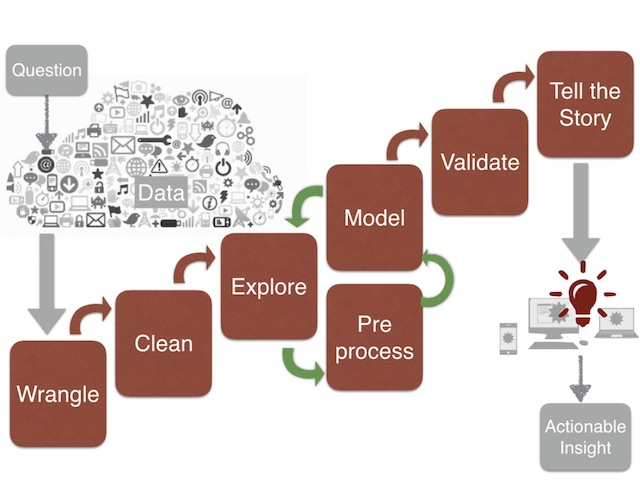

<div class="alert alert-block alert-info"><b></b></div>

## Imports:

In [1]:
import numpy as np
import pandas as pd
import wrangle
import explore

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

<div class="alert alert-block alert-info"><b></b></div>

## Data Acquisition:

<div class="alert alert-block alert-info"><b></b></div>


#### CSV Cleanup and Combination in Excel:

1. Data in CSV needed to be formatted. I chose to formatt in excel.

2. In excel only 8 of 248 daily food logs were recorded. With 97% of data missing I decided to drop the food log columns.'Calories_in' was also dropped for the same reason.

3. There are two weeks of missing rows of data at the end of the dataframe. The last activity entries were 12/6. Because no activity entries have been missing in the dataset I chose to delete the missing values after 12/6. The data for these dates will be extrapolated from modeling

4. This leaves a df that is 10 colums by 225 rows (or 225 days worth of data) where one day = one row



<div class="alert alert-block alert-info"><b></b></div>

## Data Preparation:

<div class="alert alert-block alert-info"><b></b></div>

#### Function: prepare.wrangle_fitbit_explore()

1. Reads in formatted CSV from Excel
2. Converts date to datetime
3. Sorts index by day
4. Create new features of year, month, weekday
5. Sets those features to categories for explore
6. returns df

In [2]:
df = wrangle.wrangle_fitbit_explore()
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories,Year,Month,weekday
date,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,2018.0,4.0,Thursday
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,2018.0,4.0,Friday
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,2018.0,4.0,Saturday
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,2018.0,4.0,Sunday
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,2018.0,4.0,Monday


<div class="alert alert-block alert-info"><b></b></div>

## Data Exploration:

<div class="alert alert-block alert-info"><b></b></div>

#### Function: explore.split_validate(df) 

1. Splits data set in to train (0.5), validate (0.3), and test (.2)
2. Returns print statements that verify splits have been preformed correctly

In [3]:
train, validate, test = explore.split_validate(df)
train.shape, validate.shape, test.shape

Does the length of each df equate to the length of the original df?
True
Does the first row of original df equate to the first row of train?
            calories_burned  steps  distance  floors  mins_sedentary  \
date                                                                   
2018-04-26             True   True      True    True            True   

            mins_light_active  mins_fairly_active  mins_very_active  \
date                                                                  
2018-04-26               True                True              True   

            activity_calories  Year  Month  weekday  
date                                                 
2018-04-26               True  True   True     True  
Is the last row of train the day before the first row of validate? And the same for validate to test?
Is the last row of test the same as the last row of our original dataframe?


((123, 12), (74, 12), (50, 12))

In [4]:
# def visualize_splits(df):
#     df = train.select_dtypes(include=np.number)
#     for col in df.columns:
#         plt.figure(figsize=(12,4))
#         plt.plot(train[col])
#         plt.plot(validate[col])
#         plt.plot(test[col])
#         plt.ylabel(col)
#         plt.title(col)
#         plt.show()

#### Visualize Splits

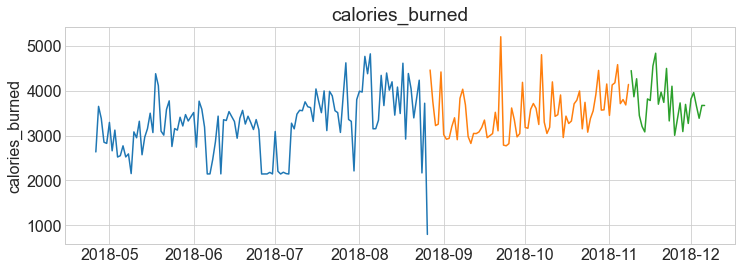

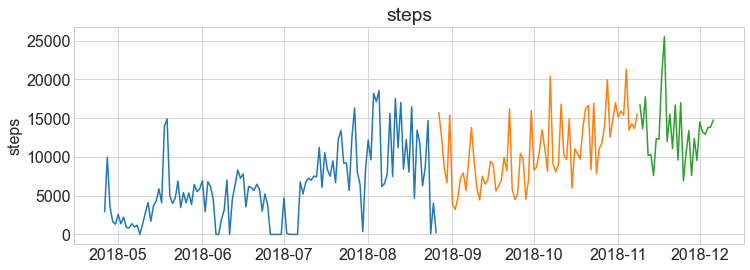

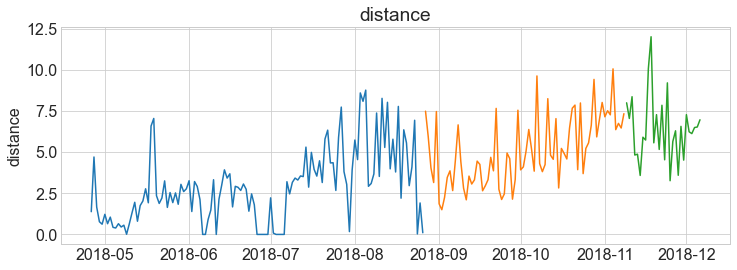

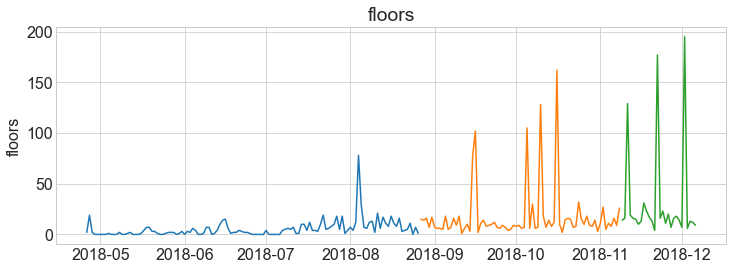

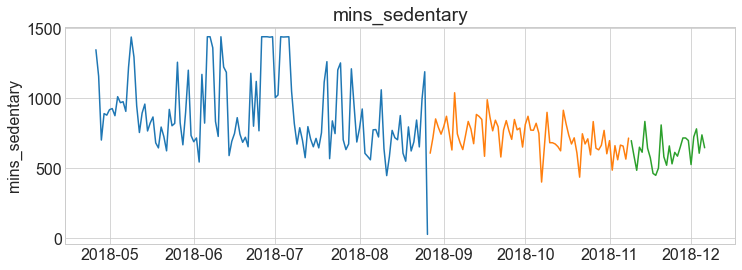

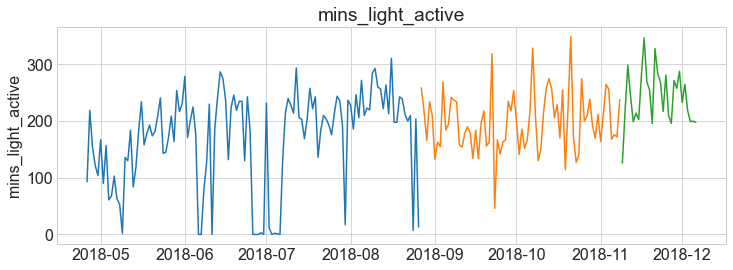

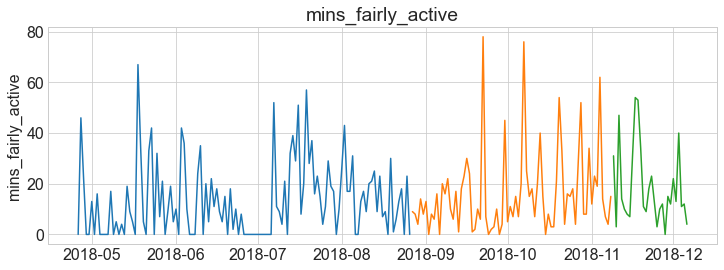

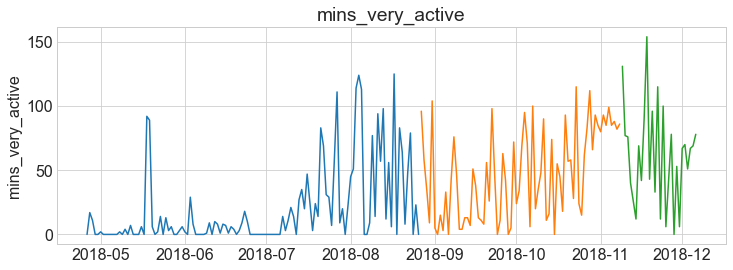

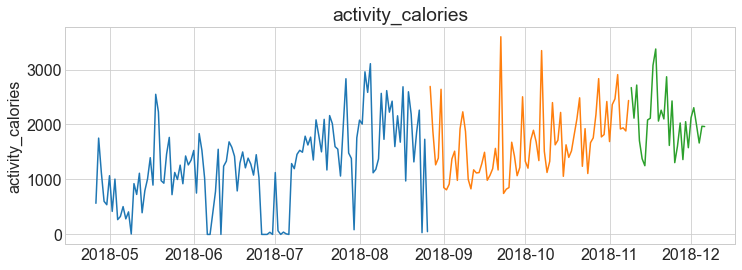

In [5]:
explore.visualize_splits(train,validate,test)